# Notebook Title - Text Classification using Transformers

In this notebook, we will explore using Transformer architecture to classify text samples.

For this, we will use the AG News Dataset from http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html which contains news items from 4 categories.

The dataset is stored at data/ag_news_csv folder

We will cover the following steps in this notebook:

1) Custom Dataset Loader

2) Word2Vec Embedding Model Training

3) Dataset EDA

4) Custom Training Loop

5) Transformer based Model Training + testing different training optimization methods

We will do the following training trials:

1) No Training Optimizations

2) Dropout Regularization

3) L1 Regularization

4) Early Stopping + Learning Rate Scheduler



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import vocab
from torchtext import data
import torchtext.transforms as T
from torch.utils.data import Dataset, DataLoader
from gensim.models import Word2Vec
from torchtext.data.utils import get_tokenizer
import torch.nn.functional as nnF
import spacy
import torchtext
import math
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from glob import glob
from collections import defaultdict
from wordcloud import WordCloud
from collections import OrderedDict

from tqdm import tqdm
import datetime
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import pickle
import os
import shutil
import random
import re
import string
import time

In [ ]:
!pip install torchinfo
import torchinfo

In [ ]:
!pip install torchmetrics
from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassROC

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 10.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
!cat "data/ag_news_csv/readme.txt"

AG's News Topic Classification Dataset

Version 3, Updated 09/09/2015


ORIGIN

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity. For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above. It is used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in 

In [ ]:
dataset_path = "data/ag_news_csv"

In [ ]:
df1 = pd.read_csv('/data/ag_news_csv/train.csv', header=None, escapechar=None)
df2 = pd.read_csv('/data/ag_news_csv/test.csv', header=None, escapechar=None)

merged_df = pd.concat([df1, df2], ignore_index=True)
merged_df.columns = ['label', 'header', 'text']
merged_df['full_text'] = merged_df['header'] + ' ' + merged_df['text']
merged_df.drop(columns = ['header', 'text'], inplace=True)
merged_df['label'] = merged_df['label'].astype(int) - 1
merged_df.to_csv('/data/ag_news_csv/dataset.csv', index=False)

print("Files merged successfully.")

Files merged successfully.


In [ ]:
labels_file_path = '/data/ag_news_csv/classes.txt'

with open(labels_file_path, 'r') as file:
    labels_list = [line.strip() for line in file]

num_classes = len(labels_list)
num_to_label = {i: label for i, label in enumerate(labels_list)}
label_to_num = {label: i for i, label in enumerate(labels_list)}

print(f"Number of Classes {num_classes}")
print(f"Classes are {labels_list}")

Number of Classes 4
Classes are ['World', 'Sports', 'Business', 'Sci/Tech']


In [ ]:
df = pd.read_csv('/data/ag_news_csv/dataset.csv', escapechar=None)
df.head()

,label,full_text
0,2,Wall St. Bears Claw Back Into the Black (Reute...
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...
4,2,"Oil prices soar to all-time record, posing new..."


In [ ]:
tokenizer = get_tokenizer("basic_english", language = "en")

## Building Vocabulary object

In [ ]:
text_data = df['full_text'].tolist()

pattern = re.compile(r'[^a-zA-Z0-9\s]')

all_tokens = []
for text in text_data:
    tokens = tokenizer(text)
    cleaned_tokens = [pattern.sub('', token) for token in tokens]  # Remove special characters
    all_tokens.extend(cleaned_tokens)

vocabulary = set(all_tokens)

# Create a Vocab object from the vocabulary
unk_token = "<unk>"
pad_token = "<pad>"
vocab = torchtext.vocab.vocab(OrderedDict([(token, 1) for token in vocabulary]), specials=[unk_token, pad_token])
default_index = -1
vocab.set_default_index(default_index)


In [ ]:
print(len(vocab))

93938


## Loading stopwords

In [ ]:
def load_stopwords(stopwords_file_path):
    with open(stopwords_file_path, 'r', encoding='utf-8') as file:
        stopwords = {line.strip() for line in file}
    return stopwords

stopwords_set = load_stopwords('data/stopwords.txt')

## EDA

In [ ]:
def calculate_average_counts(df, num_classes):
    stats_by_cat = defaultdict(dict)

    for cat in range(num_classes):
        subset_df = df[df['label'] == cat]

        total_words = 0
        total_lines = 0
        total_samples = len(subset_df)
        max_words = 0
        max_lines = 0
        min_words = float('inf')
        min_lines = float('inf')

        for content in subset_df['full_text']:
            words = tokenizer(content)
            lines = content.splitlines()

            word_count = len(words)
            line_count = len(lines)

            total_words += word_count
            total_lines += line_count

            if word_count > max_words:
                max_words = word_count
            if line_count > max_lines:
                max_lines = line_count

            if word_count < min_words:
                min_words = word_count
            if line_count < min_lines:
                min_lines = line_count

        avg_word_count = total_words / total_samples
        avg_line_count = total_lines / total_samples

        stats_by_cat[cat] = {
            'avg_word_count': avg_word_count,
            'avg_line_count': avg_line_count,
            'total_samples': total_samples,
            'max_word_count': max_words,
            'max_line_count': max_lines,
            'min_word_count': min_words,
            'min_line_count': min_lines
        }

    return stats_by_cat

In [ ]:
results = calculate_average_counts(df, num_classes)

In [ ]:
def plot_avg_word_count_combined(data, parameter):
    categories = range(num_classes)
    max_values = [data[cat]["max_"+parameter] for cat in categories]
    min_values = [data[cat]["min_"+parameter] for cat in categories]
    avg_values = [data[cat]["avg_"+parameter] for cat in categories]

    plt.figure(figsize=(12, 8))

    bar_width = 0.25
    index = np.arange(len(labels_list))

    plt.bar(index, min_values, bar_width, label='min', alpha=0.8)
    plt.bar(index + bar_width, avg_values, bar_width, label='avg', alpha=0.8)
    plt.bar(index + 2 * bar_width, max_values, bar_width, label='max', alpha=0.8)

    plt.xlabel('Category')
    plt.ylabel(parameter)
    plt.title(f'{parameter} in dataset by category')
    plt.xticks(index + 1.5*bar_width, labels_list)
    plt.legend()

    plt.show()


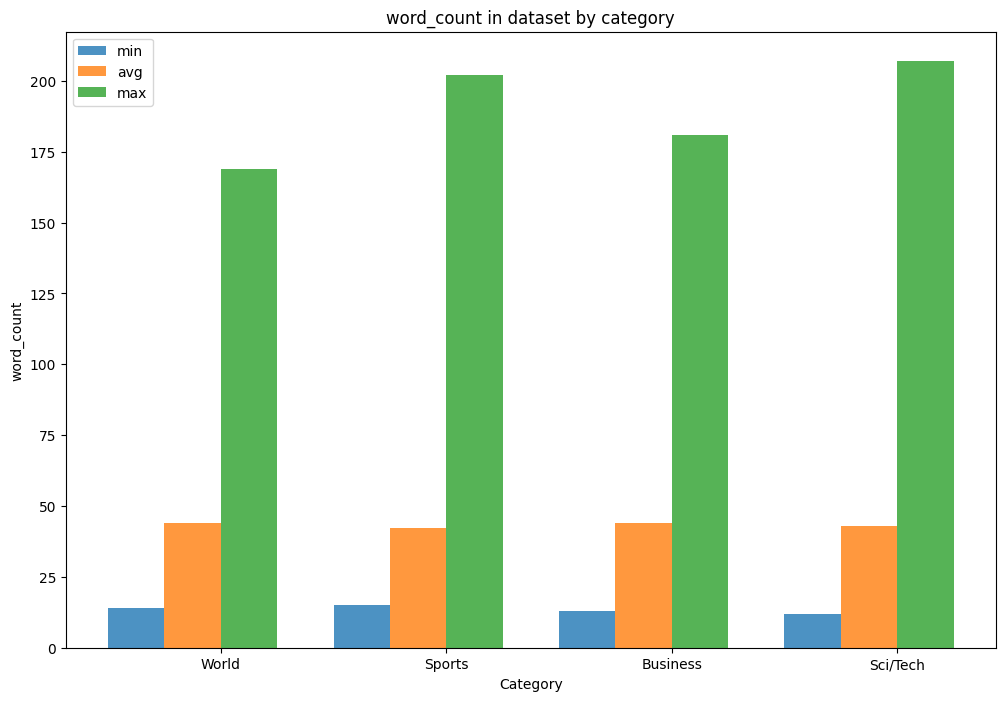

In [ ]:
plot_avg_word_count_combined(results, 'word_count')

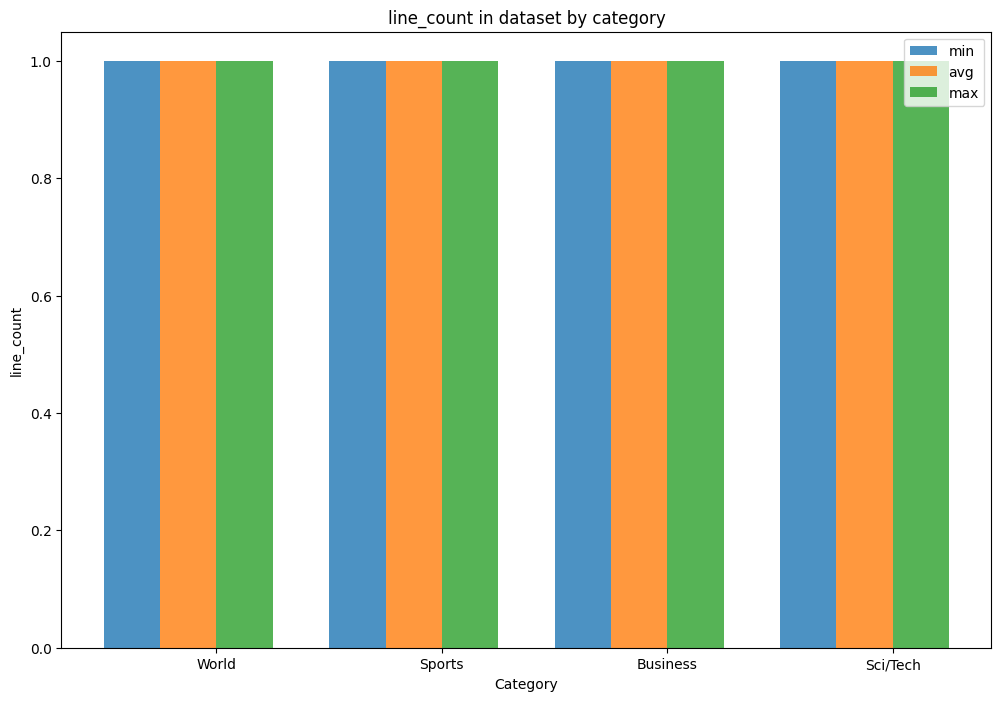

In [ ]:
plot_avg_word_count_combined(results, 'line_count')

In [ ]:
def plot_total_count_combined(data, parameter):
    categories = range(num_classes)
    values = [data[cat][parameter] for cat in categories]

    plt.figure(figsize=(6, 4))

    bar_width = 0.35
    index = np.arange(len(labels_list))

    plt.bar(index, values, bar_width, alpha=0.8)

    plt.xlabel('Category')
    plt.ylabel(parameter)
    plt.title(f'{parameter} in dataset by category')
    plt.xticks(index , labels_list)

    plt.show()

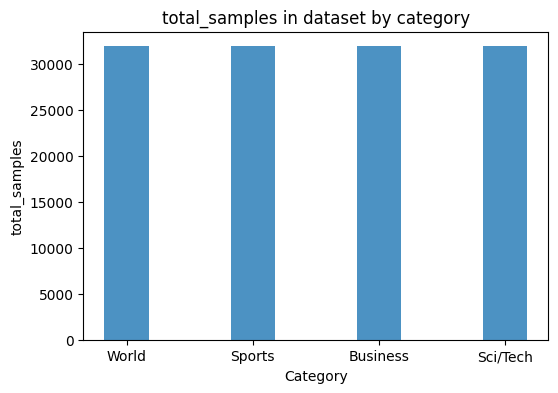

In [ ]:
plot_total_count_combined(results, 'total_samples')

In [ ]:
def generate_word_cloud(df, stopwords_set, label_value, label_text):
    text = ""

    filtered_df = df[df['label'] == label_value]

    for content in filtered_df['full_text']:
        words = tokenizer(content)
        words = [word for word in words if word in vocab and not word in stopwords_set]
        content = ' '.join(words)
        text += content + ' '

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for label {label_text}')
    plt.show()


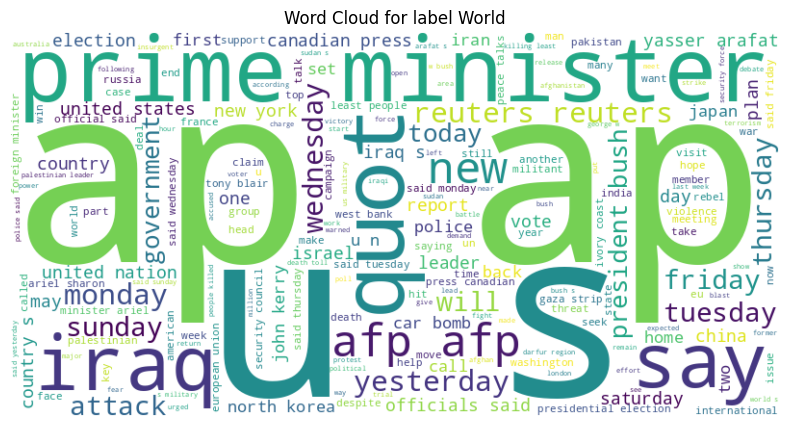

In [ ]:
generate_word_cloud(df, stopwords_set, label_value = 0, label_text = num_to_label[0])

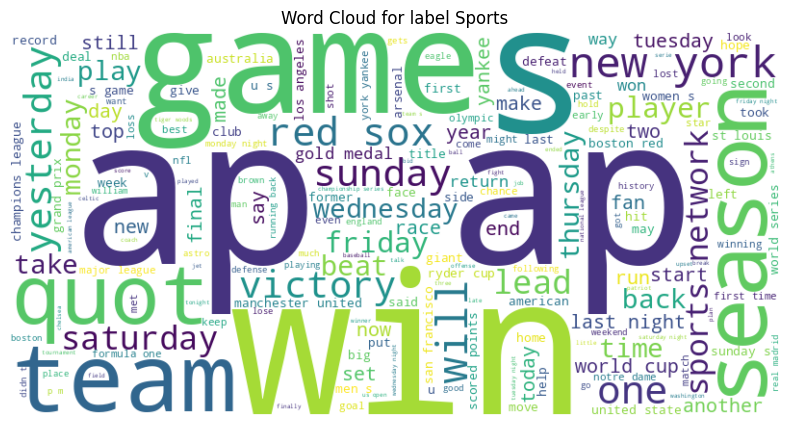

In [ ]:
generate_word_cloud(df, stopwords_set, label_value = 1, label_text = num_to_label[1])

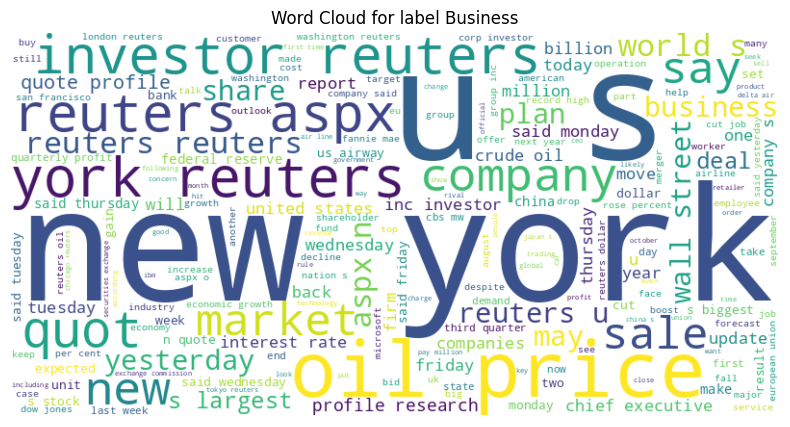

In [ ]:
generate_word_cloud(df, stopwords_set, label_value = 2, label_text = num_to_label[2])

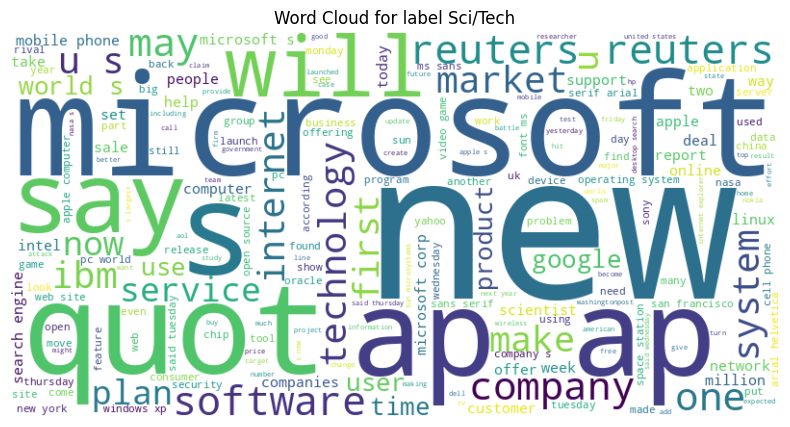

In [ ]:
generate_word_cloud(df, stopwords_set, label_value = 3, label_text = num_to_label[3])

In [ ]:
def pad_sequence(seq, max_len=300):
    if len(seq) > max_len:
        return seq[:max_len]
    else:
        return seq + [vocab.stoi['<pad>']] * (max_len - len(seq))

## Training Embedding Model

In [ ]:
# Word2Vec embedding
embedding_size = 100
max_seq_length = 50
vocab_size = 40000
tokenized_comments = []

for text in df['full_text']:
    tokens = tokenizer(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords_set]
    tokenized_comments.append(filtered_tokens)

word2vec_model = Word2Vec(sentences=tokenized_comments,
                            vector_size=embedding_size,
                            max_final_vocab = vocab_size,
                            window = 5,
                            workers=4,
                            sg=1,
                            epochs=20)
    

100%|██████████| 127600/127600 [00:00<00:00, 144310.53it/s]


In [ ]:
word2vec_model.wv.most_similar('bad')

[('good', 0.714983344078064),
 ('worse', 0.5799961686134338),
 ('selfish', 0.5764060616493225),
 ('sometimes', 0.5692639350891113),
 ('indifference', 0.563718318939209),
 ('unforeseen', 0.5634217262268066),
 ('vibes', 0.5509824752807617),
 ('roller-coaster', 0.5448659658432007),
 ('wilbon', 0.5431843400001526),
 ('blip', 0.541020393371582)]

In [ ]:
word2vec_model.wv.most_similar('good')

[('bad', 0.7149832844734192),
 ('really', 0.664991557598114),
 ('better', 0.6585500836372375),
 ('pretty', 0.6411454677581787),
 ('lot', 0.6357435584068298),
 ('re', 0.6285344958305359),
 ('wilbon', 0.6255343556404114),
 ('sure', 0.6198322772979736),
 ('knows', 0.6159226298332214),
 ('selfish', 0.6151955127716064)]

In [ ]:
word2vec_model.wv.most_similar('great')

[('always', 0.5914850831031799),
 ('sucking', 0.572916567325592),
 ('lakes', 0.5701320767402649),
 ('culinary', 0.5623955726623535),
 ('cricketing', 0.5540429949760437),
 ('paavo', 0.5479708313941956),
 ('placental', 0.5451008677482605),
 ('chimp', 0.54410320520401),
 ('hendrik', 0.5438075661659241),
 ('apes', 0.5382757186889648)]

## Custom Dataset

In [ ]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, vocab, max_seq_length, word2vec_model, load_and_embed=True):
        self.df = df
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.max_seq_length = max_seq_length
        self.word2vec_model = word2vec_model
        self.load_and_embed = load_and_embed
        if self.load_and_embed:
            self.data, self.labels = self.load_and_embed_data()
        else:
            self.data, self.labels = self.load_data()

    def load_data(self):
        data = []
        labels = []
        for idx, row in tqdm(self.df.iterrows(), total=len(self.df), desc="Loading data"):
            text = row['full_text']
            label = row['label']
            data.append(text)
            labels.append(label)
        return data, labels

    def load_and_embed_data(self):
        data = []
        labels = []
        for idx, row in tqdm(self.df.iterrows(), total=len(self.df), desc="Loading and embedding data"):
            text = row['full_text']
            label = row['label']
            data.append(self.embedding(text))
            labels.append(label)
        return data, labels

    def tokenize(self, text):
        tokens = self.tokenizer(text)
        return tokens

    def pad_sequence(self, text):
        if len(text) > self.max_seq_length:
            return text[:self.max_seq_length]
        else:
            return text + self.vocab.forward(['<pad>']) * (self.max_seq_length - len(text))

    def embedding(self, text):
        word2vec_output = [self.word2vec_model.wv[word] for word in self.tokenize(text) if word in self.word2vec_model.wv]
        if len(word2vec_output) < self.max_seq_length:
            padding = [np.zeros(self.word2vec_model.vector_size)] * (self.max_seq_length - len(word2vec_output))
            word2vec_output += padding
        else:
            word2vec_output = word2vec_output[:self.max_seq_length]
        return word2vec_output

    def __len__(self):
        return len(self.data)

    def __getitem__(self, indices):
        if isinstance(indices, int):
            indices = [indices]
        elif isinstance(indices, slice):
            indices = list(range(*indices.indices(len(self))))

        if not self.load_and_embed:
            samples = {'text': np.stack([self.embedding(self.data[idx]) for idx in indices], axis=0), 'label': [self.labels[idx] for idx in indices]}
        else:
            samples = {'text': np.stack([self.data[idx] for idx in indices], axis=0), 'label': [self.labels[idx] for idx in indices]}
        samples['text'] = torch.tensor(samples['text'], dtype=torch.float32)
        samples['label'] = torch.tensor(samples['label'], dtype=torch.float32)
        return samples

    def collate_fn(self, batch):
        texts = torch.stack([item['text'] for item in batch]).squeeze(dim=1)
        labels = torch.tensor([item['label'] for item in batch]).view(-1, 1)
        return {'text': texts, 'label': labels}

In [ ]:
df.head()

,label,full_text
0,2,Wall St. Bears Claw Back Into the Black (Reute...
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...
4,2,"Oil prices soar to all-time record, posing new..."


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.3)
valid_df, test_df = train_test_split(test_df, test_size=0.5)

In [ ]:
train_dataset = TextDataset(train_df, tokenizer, vocab, max_seq_length = max_seq_length, word2vec_model = word2vec_model, load_and_embed = True)
test_dataset = TextDataset(test_df, tokenizer, vocab, max_seq_length = max_seq_length, word2vec_model = word2vec_model, load_and_embed = True)
valid_dataset = TextDataset(valid_df, tokenizer, vocab, max_seq_length = max_seq_length, word2vec_model = word2vec_model, load_and_embed = True)

Loading and embedding data: 100%|██████████| 19140/19140 [00:03<00:00, 5971.10it/s]


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, collate_fn=train_dataset.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=test_dataset.collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=valid_dataset.collate_fn)

In [ ]:
train_dataset_size = len(train_loader.dataset)
test_dataset_size = len(test_loader.dataset)
validation_dataset_size = len(valid_loader.dataset)

print("Train Dataset Size : {}".format(train_dataset_size))
print("Validation Dataset Size : {}".format(validation_dataset_size))
print("Test Dataset Size : {}".format(test_dataset_size))

Train Dataset Size : 89320
Validation Dataset Size : 19140
Test Dataset Size : 19140


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
test_iter = iter(test_loader)
batch = next(test_iter)
print(batch['text'].shape)
print(batch['label'].shape)
print(batch['text'][:5])
print(batch['label'][:5])

torch.Size([32, 50, 100])
torch.Size([32, 1])
tensor([[[-0.3354,  0.3120, -0.8294,  ..., -0.2590,  0.6894,  0.4142],
         [ 0.8329, -0.0946,  0.2342,  ..., -0.6777,  0.1861,  0.0284],
         [-0.0341, -0.0114,  0.5736,  ..., -0.7606,  0.3688, -0.6742],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.3769,  0.6659,  0.2570,  ...,  0.1409,  0.0202,  0.6436],
         [ 0.9214,  1.1474, -0.0094,  ...,  0.3639,  0.1418,  0.8983],
         [-0.1419,  0.3254,  0.2516,  ..., -0.2837, -0.1739, -0.0859],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.1348,  0.2380,  0.1060,  ...,  0.1358,  0.1779, -0.4061],

## Custom Model Training Loop

In [ ]:
class ModelTrial():
    def __init__(self, model, criterion, optimizer, scheduler, l1_lambda = 0):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_metrics = {'accuracy': [], 'loss': []}
        self.validation_metrics = {'accuracy': [], 'loss': []}
        self.test_metrics = {'accuracy': [], 'loss': []}
        self.train_time = None
        self.epochs = []
        self.test_outputs = {}
        self.l1_lambda = l1_lambda
        self.softmax = nn.Softmax(dim=1)
    def printModel(self):
        print(self.model)
    def printModelSummary(self, input_size):
        print(torchinfo.summary(self.model, input_size = input_size))
    def trainingLoop(self, trainLoader, validationLoader, num_epochs, temp_model_path, final_model_path, trial_save_path, verbose = True, lr_scheduler = True, early_stop = True, patience = 10):
        self.train_metrics = {'accuracy': [], 'loss': []}
        self.validation_metrics = {'accuracy': [], 'loss': []}
        self.test_metrics = {'accuracy': [], 'loss': []}
        self.test_outputs = {}
        self.epochs = range(1, num_epochs+1)
        cumulative_train_time = datetime.timedelta()
        min_validation_loss = float('inf')
        patience_ctr = 0
        break_epoch = self.epochs[-1]
        for epoch in self.epochs:
            print(f"In Epoch {epoch}")
            training_loss = 0.0
            training_correct = 0
            t1 = datetime.datetime.now()
            self.model.train()
            for batch_idx, batch_data in enumerate(tqdm(trainLoader)):
                inputs = batch_data['text'].squeeze(dim=1).to(device)
                labels = batch_data['label'].to(device).squeeze(dim=1).long()
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                y_pred = torch.max(self.softmax(outputs), 1).indices
                loss = self.criterion(outputs, labels)
                if self.l1_lambda:
                    l1_reg = torch.tensor(0., requires_grad=True)
                    for param in self.model.parameters():
                        l1_reg = l1_reg + torch.norm(param, 1)
                    loss = loss + self.l1_lambda * l1_reg

                loss.backward()
                self.optimizer.step()
                training_loss += loss.item() / (train_dataset_size / trainLoader.batch_size)
                training_correct += (y_pred == labels).sum().item()

            t2 = datetime.datetime.now()
            cumulative_train_time += t2-t1

            training_accuracy = 100 * training_correct / train_dataset_size
            if verbose:
                print(f"Epoch {epoch}, Training Loss: {training_loss:.5f}, Training Accuracy: {training_accuracy:.2f}%")
            self.train_metrics['accuracy'].append(training_accuracy)
            self.train_metrics['loss'].append(training_loss)
            # Validation loop
            validation_loss = 0.0
            validation_correct = 0
            self.model.eval()
            with torch.no_grad():  # Disable gradient computation
                for batch_idx, batch_data in enumerate(tqdm(validationLoader)):
                    inputs = batch_data['text'].squeeze(dim=1).to(device)
                    labels = batch_data['label'].to(device).squeeze(dim=1).long()
                    outputs = self.model(inputs)
                    y_pred = torch.max(self.softmax(outputs), 1).indices
                    loss = self.criterion(outputs, labels)
                    validation_loss += loss.item() / (validation_dataset_size / validationLoader.batch_size)

                    validation_correct += (y_pred == labels).sum().item()
                validation_accuracy = 100 * validation_correct / validation_dataset_size
                if verbose:
                    print(f"Epoch {epoch}, Validation Loss: {validation_loss:.5f}, Validation Accuracy: {validation_accuracy:.2f}%")
                self.validation_metrics['accuracy'].append(validation_accuracy)
                self.validation_metrics['loss'].append(validation_loss)
            if lr_scheduler:
                self.scheduler.step(validation_loss)
            if early_stop:
                if validation_loss <= min_validation_loss:
                    min_validation_loss = validation_loss
                    patience_counter = 0
                    self.saveModel(temp_model_path)
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print("\nEarly stopping")
                        break_epoch = epoch
                        self.loadModel(temp_model_path)
                        break
        self.epochs = self.epochs[:break_epoch]
        self.train_time = cumulative_train_time
        print("Training Ended !!!")
        self.saveModel(final_model_path)
        self.saveTrial(trial_save_path)

    def testDatasetPass(self, testLoader):
        self.model.eval()
        test_loss = 0.0
        test_correct = 0
        test_labels = torch.Tensor([]).to(device)
        test_pred = torch.Tensor([]).to(device)
        test_outputs = torch.Tensor([]).to(device)
        print(f"Testing Started!")
        with torch.no_grad():
            for batch_idx, batch_data in enumerate(tqdm(testLoader)):
                inputs = batch_data['text'].squeeze(dim=1).to(device)
                labels = batch_data['label'].to(device).squeeze(dim=1).long()
                outputs = self.model(inputs)
                y_pred = torch.max(self.softmax(outputs), 1).indices
                loss = self.criterion(outputs, labels)
                test_loss += loss.item() / (test_dataset_size / testLoader.batch_size)
                test_correct += (y_pred == labels).sum().item()
                test_labels = torch.cat((test_labels,labels),dim = 0)
                test_pred = torch.cat((test_pred,y_pred), dim = 0)
                test_outputs = torch.cat((test_outputs,outputs), dim = 0)

        test_accuracy = 100 * test_correct / test_dataset_size
        self.test_metrics['accuracy'] = [test_accuracy]*(len(self.epochs))
        self.test_metrics['loss'] = [test_loss]*(len(self.epochs))
        self.test_outputs['accuracy'] = test_accuracy
        self.test_outputs['labels'] = test_labels
        self.test_outputs['y_pred'] = test_pred
        self.test_outputs['outputs'] = test_outputs
        print(f"Testing Completed!!")
        print(f"Testing Loss: {test_loss:.5f}, Testing Accuracy: {test_accuracy:.2f}%")

    def printTrainTimeStatistics(self):
        print("Time taken to train model (train phase alone considered) is : ")
        days = self.train_time.days
        seconds = self.train_time.seconds
        microseconds = self.train_time.microseconds
        hours, remainder = divmod(seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f"Days: {days}, Hours: {hours}, Minutes: {minutes}, Seconds: {seconds}, Microseconds: {microseconds}")

    def plotLossVsEpochs(self):
        fig = plt.figure()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        plt.plot(self.epochs, self.test_metrics['loss'], label = 'Test')
        plt.plot(self.epochs, self.validation_metrics['loss'], label = 'Validation')
        plt.plot(self.epochs, self.train_metrics['loss'], label = 'Train')

        plt.title('Loss vs Epochs graph for Train, Test and Validation Dataset')
        plt.legend()
        plt.show()

    def plotAccuracyVsEpochs(self):
        fig = plt.figure()
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')

        plt.plot(self.epochs, self.test_metrics['accuracy'], label = 'Test')
        plt.plot(self.epochs, self.validation_metrics['accuracy'], label = 'Validation')
        plt.plot(self.epochs, self.train_metrics['accuracy'], label = 'Train')

        plt.title('Accuracy vs Epochs graph for Train, Test and Validation Dataset')
        plt.legend()
        plt.show()

    def printMetrics(self):
        precision, recall, fscore, _ = precision_recall_fscore_support(y_true = self.test_outputs['labels'].cpu().numpy(), y_pred = self.test_outputs['y_pred'].cpu().numpy(), average=None,labels=[float(i) for i in range(self.model.num_classes)])
        print(f"Accuracy for Test Dataset at end of training : {self.test_outputs['accuracy']:.5f}")
        for class_label, precision, recall, fscore in zip(range(len(precision)), precision, recall, fscore):
            print(f"For Class {num_to_label[class_label]}: Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={fscore:.4f}")


    def plotConfusionMatrix(self):
        bcm = MulticlassConfusionMatrix(self.model.num_classes).to(device)
        bcm.update(self.test_outputs['y_pred'], self.test_outputs['labels'])
        fig, ax = plt.subplots()
        bcm.plot(ax = ax)
        plt.title('Confusion Matrix for Test Dataset')
        plt.plot()

    def plotROCgraph(self):
        broc = MulticlassROC(self.model.num_classes)
        broc.update(self.test_outputs['outputs'], self.test_outputs['labels'].type(torch.int64))
        fig, ax = plt.subplots()
        broc.plot(score=True, ax = ax)
        plt.title('ROC Curve for Test Dataset')
        plt.show()

    def saveModel(self, path):
        torch.save(self.model.state_dict(), path)

    def loadModel(self, path):
        loadedModel = torch.load(path)
        self.model.load_state_dict(loadedModel)

    def saveTrial(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self, f)

    def loadTrial(self, path):
        with open(path, 'rb') as f:
            self = pickle.load(f)

# Base Transformer Model

In [ ]:
lr=0.01
num_epochs = 20
l1_lambda = 0
l2_lambda = 0
early_stop = False
earlyStopPatience = 10
lr_scheduler = False
lrsPatience = 5
dropoutProb = 0
nheads = 4
num_layers = 3
hidden_size = 100
vocab_size = vocab_size
embedding_size = embedding_size
max_seq_length = max_seq_length
num_classes = num_classes
temp_model_path = '/content/textclassification/temp.pth'
final_model_path = '/content/textclassification/base.pth'
trial_save_path = '/content/textclassification/base.pkl'

In [ ]:
class BaseTransformer(nn.Module):
    def __init__(self, vocab_size, embedding_size, max_seq_len, num_classes, nheads, hidden_size, num_layers, dropout):
        super(BaseTransformer, self).__init__()
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.pos_encoder = PositionalEncoding(embedding_size, dropout, max_seq_len)
        encoder_layers = TransformerEncoderLayer(embedding_size, nheads, hidden_size, dropout, batch_first = True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.linear = nn.Linear(embedding_size, num_classes)

    def forward(self, src):
        src = src * math.sqrt(self.embedding_size)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output[:, -1, :].squeeze(1)
        output = self.linear(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, embedding_size, dropout, max_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_size, 2) * (-math.log(10000.0) / embedding_size))
        pe = torch.zeros(1, max_len, embedding_size)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe
        return self.dropout(x)

In [ ]:
baseTransformer = BaseTransformer(
    vocab_size = vocab_size,
    embedding_size = embedding_size,
    max_seq_len = max_seq_length,
    num_classes = num_classes,
    nheads = nheads,
    hidden_size = hidden_size,
    num_layers = num_layers,
    dropout = dropoutProb
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseTransformer.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, threshold_mode = 'rel', mode = 'min', patience=lrsPatience, threshold=0.0001)

In [ ]:
baseModel = ModelTrial(baseTransformer, criterion, optimizer, scheduler = scheduler, l1_lambda = l1_lambda)

In [ ]:
baseModel.printModel()

BaseTransformer(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=100, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=100, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
    )
  )
  (linear): Linear(in_features=100, out_features=4, bias=True)
)


In [ ]:
baseModel.printModelSummary((256, max_seq_length, embedding_size))

Layer (type:depth-idx)                        Output Shape              Param #
BaseTransformer                               [256, 4]                  --
├─PositionalEncoding: 1-1                     [256, 50, 100]            --
│    └─Dropout: 2-1                           [256, 50, 100]            --
├─TransformerEncoder: 1-2                     [256, 50, 100]            --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [256, 50, 100]            61,000
│    │    └─TransformerEncoderLayer: 3-2      [256, 50, 100]            61,000
│    │    └─TransformerEncoderLayer: 3-3      [256, 50, 100]            61,000
├─Linear: 1-3                                 [256, 4]                  404
Total params: 183,404
Trainable params: 183,404
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 5.12
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 5.13


In [ ]:
baseModel.trainingLoop(trainLoader = train_loader, validationLoader = valid_loader,
                         num_epochs = num_epochs,
                         temp_model_path = temp_model_path,
                         final_model_path = final_model_path,
                         trial_save_path = trial_save_path,
                         verbose = True, lr_scheduler = lr_scheduler,
                         early_stop = early_stop, patience = earlyStopPatience)

In Epoch 1


100%|██████████| 349/349 [00:10<00:00, 34.75it/s]


Epoch 1, Training Loss: 0.64818, Training Accuracy: 76.82%


100%|██████████| 599/599 [00:02<00:00, 236.97it/s]


Epoch 1, Validation Loss: 0.74093, Validation Accuracy: 72.54%
In Epoch 2


100%|██████████| 349/349 [00:10<00:00, 33.35it/s]


Epoch 2, Training Loss: 0.74261, Training Accuracy: 70.92%


100%|██████████| 599/599 [00:02<00:00, 248.65it/s]


Epoch 2, Validation Loss: 0.61870, Validation Accuracy: 76.58%
In Epoch 3


100%|██████████| 349/349 [00:10<00:00, 32.11it/s]


Epoch 3, Training Loss: 0.69792, Training Accuracy: 73.04%


100%|██████████| 599/599 [00:02<00:00, 240.87it/s]


Epoch 3, Validation Loss: 0.66371, Validation Accuracy: 74.85%
In Epoch 4


100%|██████████| 349/349 [00:10<00:00, 31.84it/s]


Epoch 4, Training Loss: 0.60083, Training Accuracy: 77.71%


100%|██████████| 599/599 [00:02<00:00, 225.18it/s]


Epoch 4, Validation Loss: 0.55134, Validation Accuracy: 79.81%
In Epoch 5


100%|██████████| 349/349 [00:10<00:00, 34.54it/s]


Epoch 5, Training Loss: 0.50477, Training Accuracy: 81.97%


100%|██████████| 599/599 [00:02<00:00, 225.06it/s]


Epoch 5, Validation Loss: 0.48161, Validation Accuracy: 83.15%
In Epoch 6


100%|██████████| 349/349 [00:10<00:00, 33.08it/s]


Epoch 6, Training Loss: 0.46161, Training Accuracy: 84.08%


100%|██████████| 599/599 [00:02<00:00, 243.54it/s]


Epoch 6, Validation Loss: 0.44622, Validation Accuracy: 84.63%
In Epoch 7


100%|██████████| 349/349 [00:10<00:00, 33.00it/s]


Epoch 7, Training Loss: 0.44485, Training Accuracy: 84.83%


100%|██████████| 599/599 [00:02<00:00, 234.38it/s]


Epoch 7, Validation Loss: 0.46368, Validation Accuracy: 84.54%
In Epoch 8


100%|██████████| 349/349 [00:10<00:00, 33.60it/s]


Epoch 8, Training Loss: 0.44810, Training Accuracy: 84.70%


100%|██████████| 599/599 [00:02<00:00, 223.21it/s]


Epoch 8, Validation Loss: 0.54168, Validation Accuracy: 80.25%
In Epoch 9


100%|██████████| 349/349 [00:10<00:00, 33.55it/s]


Epoch 9, Training Loss: 0.45564, Training Accuracy: 84.37%


100%|██████████| 599/599 [00:02<00:00, 221.87it/s]


Epoch 9, Validation Loss: 0.43450, Validation Accuracy: 85.29%
In Epoch 10


100%|██████████| 349/349 [00:10<00:00, 33.64it/s]


Epoch 10, Training Loss: 0.43691, Training Accuracy: 85.03%


100%|██████████| 599/599 [00:02<00:00, 238.04it/s]


Epoch 10, Validation Loss: 0.45163, Validation Accuracy: 84.17%
In Epoch 11


100%|██████████| 349/349 [00:10<00:00, 32.74it/s]


Epoch 11, Training Loss: 0.43648, Training Accuracy: 85.16%


100%|██████████| 599/599 [00:02<00:00, 233.52it/s]


Epoch 11, Validation Loss: 0.42334, Validation Accuracy: 85.59%
In Epoch 12


100%|██████████| 349/349 [00:10<00:00, 34.09it/s]


Epoch 12, Training Loss: 0.63951, Training Accuracy: 75.88%


100%|██████████| 599/599 [00:02<00:00, 225.67it/s]


Epoch 12, Validation Loss: 0.63293, Validation Accuracy: 77.15%
In Epoch 13


100%|██████████| 349/349 [00:10<00:00, 34.70it/s]


Epoch 13, Training Loss: 0.65888, Training Accuracy: 75.99%


100%|██████████| 599/599 [00:02<00:00, 222.03it/s]


Epoch 13, Validation Loss: 0.57604, Validation Accuracy: 79.52%
In Epoch 14


100%|██████████| 349/349 [00:11<00:00, 31.00it/s]


Epoch 14, Training Loss: 0.53109, Training Accuracy: 81.20%


100%|██████████| 599/599 [00:02<00:00, 227.51it/s]


Epoch 14, Validation Loss: 0.50304, Validation Accuracy: 82.47%
In Epoch 15


100%|██████████| 349/349 [00:10<00:00, 32.76it/s]


Epoch 15, Training Loss: 0.57946, Training Accuracy: 79.42%


100%|██████████| 599/599 [00:02<00:00, 249.89it/s]


Epoch 15, Validation Loss: 0.58744, Validation Accuracy: 78.49%
In Epoch 16


100%|██████████| 349/349 [00:10<00:00, 33.73it/s]


Epoch 16, Training Loss: 0.61193, Training Accuracy: 77.65%


100%|██████████| 599/599 [00:02<00:00, 229.39it/s]


Epoch 16, Validation Loss: 0.56452, Validation Accuracy: 80.05%
In Epoch 17


100%|██████████| 349/349 [00:10<00:00, 34.70it/s]


Epoch 17, Training Loss: 0.73389, Training Accuracy: 71.14%


100%|██████████| 599/599 [00:02<00:00, 220.19it/s]


Epoch 17, Validation Loss: 0.58265, Validation Accuracy: 79.35%
In Epoch 18


100%|██████████| 349/349 [00:10<00:00, 33.31it/s]


Epoch 18, Training Loss: 0.59152, Training Accuracy: 79.25%


100%|██████████| 599/599 [00:02<00:00, 249.03it/s]


Epoch 18, Validation Loss: 0.51485, Validation Accuracy: 82.50%
In Epoch 19


100%|██████████| 349/349 [00:09<00:00, 35.68it/s]


Epoch 19, Training Loss: 0.57477, Training Accuracy: 79.98%


100%|██████████| 599/599 [00:02<00:00, 252.52it/s]


Epoch 19, Validation Loss: 0.62421, Validation Accuracy: 77.31%
In Epoch 20


100%|██████████| 349/349 [00:09<00:00, 35.71it/s]


Epoch 20, Training Loss: 0.59013, Training Accuracy: 78.78%


100%|██████████| 599/599 [00:02<00:00, 257.78it/s]


Epoch 20, Validation Loss: 0.57672, Validation Accuracy: 79.46%
Training Ended !!!


In [ ]:
baseModel.testDatasetPass(test_loader)

Testing Started!


100%|██████████| 599/599 [00:02<00:00, 246.14it/s]

Testing Completed!!
Testing Loss: 0.59083, Testing Accuracy: 79.08%


In [ ]:
baseModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 3, Seconds: 28, Microseconds: 138142


In [ ]:
baseModel.printMetrics()

Accuracy for Test Dataset at end of training : 79.08046
For Class World: Precision=0.7964, Recall=0.7618, F1 Score=0.7787
For Class Sports: Precision=0.8931, Recall=0.9098, F1 Score=0.9014
For Class Business: Precision=0.6836, Recall=0.8606, F1 Score=0.7619
For Class Sci/Tech: Precision=0.8223, Recall=0.6376, F1 Score=0.7183


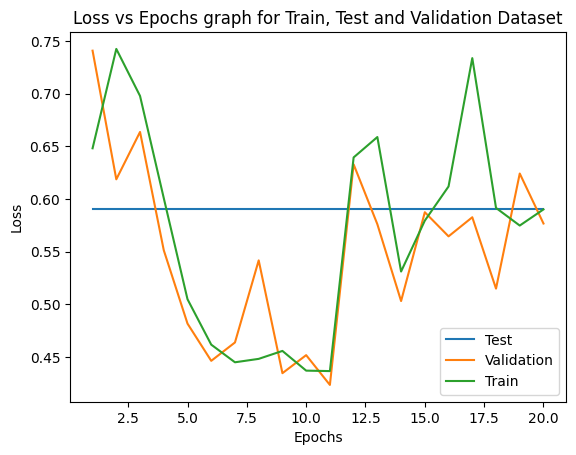

In [ ]:
baseModel.plotLossVsEpochs()

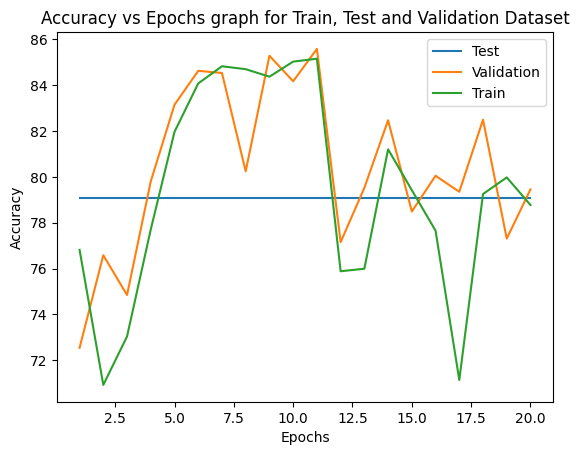

In [ ]:
baseModel.plotAccuracyVsEpochs()

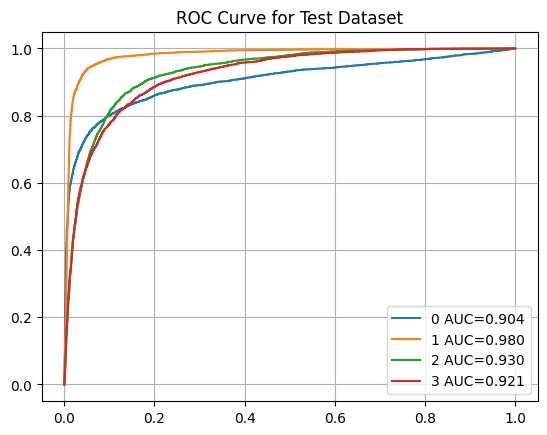

In [ ]:
baseModel.plotROCgraph()

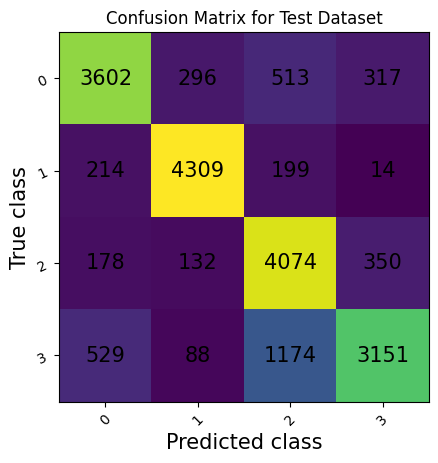

In [ ]:
baseModel.plotConfusionMatrix()

# Base Transformer Model with Dropout

In [ ]:
lr=0.01
num_epochs = 20
l1_lambda = 0
l2_lambda = 0
early_stop = False
earlyStopPatience = 10
lr_scheduler = False
lrsPatience = 5
dropoutProb = 0.2
nheads = 4
num_layers = 3
hidden_size = 100
vocab_size = vocab_size
embedding_size = embedding_size
max_seq_length = max_seq_length
num_classes = num_classes
temp_model_path = '/content/textclassification/temp.pth'
final_model_path = '/content/textclassification/dropout.pth'
trial_save_path = '/content/textclassification/dropout.pkl'

In [ ]:
dropoutTransformer = BaseTransformer(
    vocab_size = vocab_size,
    embedding_size = embedding_size,
    max_seq_len = max_seq_length,
    num_classes = num_classes,
    nheads = nheads,
    hidden_size = hidden_size,
    num_layers = num_layers,
    dropout = dropoutProb
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dropoutTransformer.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, threshold_mode = 'rel', mode = 'min', patience=lrsPatience, threshold=0.0001)

In [ ]:
dropoutModel = ModelTrial(dropoutTransformer, criterion, optimizer, scheduler = scheduler, l1_lambda = l1_lambda)

In [ ]:
dropoutModel.printModel()

BaseTransformer(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=100, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=100, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (linear): Linear(in_features=100, out_features=4, bias=True)
)


In [ ]:
dropoutModel.printModelSummary((256, max_seq_length, embedding_size))

Layer (type:depth-idx)                        Output Shape              Param #
BaseTransformer                               [256, 4]                  --
├─PositionalEncoding: 1-1                     [256, 50, 100]            --
│    └─Dropout: 2-1                           [256, 50, 100]            --
├─TransformerEncoder: 1-2                     [256, 50, 100]            --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [256, 50, 100]            61,000
│    │    └─TransformerEncoderLayer: 3-2      [256, 50, 100]            61,000
│    │    └─TransformerEncoderLayer: 3-3      [256, 50, 100]            61,000
├─Linear: 1-3                                 [256, 4]                  404
Total params: 183,404
Trainable params: 183,404
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 5.12
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 5.13


In [ ]:
dropoutModel.trainingLoop(trainLoader = train_loader, validationLoader = valid_loader,
                         num_epochs = num_epochs,
                         temp_model_path = temp_model_path,
                         final_model_path = final_model_path,
                         trial_save_path = trial_save_path,
                         verbose = True, lr_scheduler = lr_scheduler,
                         early_stop = early_stop, patience = earlyStopPatience)

In Epoch 1


100%|██████████| 349/349 [00:10<00:00, 32.48it/s]


Epoch 1, Training Loss: 0.58439, Training Accuracy: 80.34%


100%|██████████| 599/599 [00:02<00:00, 224.18it/s]


Epoch 1, Validation Loss: 0.48076, Validation Accuracy: 84.73%
In Epoch 2


100%|██████████| 349/349 [00:11<00:00, 31.22it/s]


Epoch 2, Training Loss: 0.46775, Training Accuracy: 85.01%


100%|██████████| 599/599 [00:02<00:00, 242.97it/s]


Epoch 2, Validation Loss: 0.43028, Validation Accuracy: 87.10%
In Epoch 3


100%|██████████| 349/349 [00:10<00:00, 34.34it/s]


Epoch 3, Training Loss: 0.44012, Training Accuracy: 86.03%


100%|██████████| 599/599 [00:02<00:00, 242.19it/s]


Epoch 3, Validation Loss: 0.39091, Validation Accuracy: 88.03%
In Epoch 4


100%|██████████| 349/349 [00:10<00:00, 33.22it/s]


Epoch 4, Training Loss: 0.49160, Training Accuracy: 84.26%


100%|██████████| 599/599 [00:02<00:00, 239.63it/s]


Epoch 4, Validation Loss: 0.49143, Validation Accuracy: 85.38%
In Epoch 5


100%|██████████| 349/349 [00:10<00:00, 33.38it/s]


Epoch 5, Training Loss: 0.78624, Training Accuracy: 69.10%


100%|██████████| 599/599 [00:02<00:00, 248.80it/s]


Epoch 5, Validation Loss: 0.83644, Validation Accuracy: 61.16%
In Epoch 6


100%|██████████| 349/349 [00:10<00:00, 34.54it/s]


Epoch 6, Training Loss: 1.08463, Training Accuracy: 50.59%


100%|██████████| 599/599 [00:02<00:00, 242.95it/s]


Epoch 6, Validation Loss: 1.48534, Validation Accuracy: 24.79%
In Epoch 7


100%|██████████| 349/349 [00:10<00:00, 33.83it/s]


Epoch 7, Training Loss: 1.22909, Training Accuracy: 43.13%


100%|██████████| 599/599 [00:02<00:00, 248.04it/s]


Epoch 7, Validation Loss: 1.14481, Validation Accuracy: 47.29%
In Epoch 8


100%|██████████| 349/349 [00:10<00:00, 33.95it/s]


Epoch 8, Training Loss: 1.15125, Training Accuracy: 46.50%


100%|██████████| 599/599 [00:02<00:00, 255.18it/s]


Epoch 8, Validation Loss: 1.03518, Validation Accuracy: 52.71%
In Epoch 9


100%|██████████| 349/349 [00:10<00:00, 33.09it/s]


Epoch 9, Training Loss: 1.10397, Training Accuracy: 49.60%


100%|██████████| 599/599 [00:02<00:00, 248.93it/s]


Epoch 9, Validation Loss: 1.07382, Validation Accuracy: 49.48%
In Epoch 10


100%|██████████| 349/349 [00:10<00:00, 32.03it/s]


Epoch 10, Training Loss: 1.08859, Training Accuracy: 49.61%


100%|██████████| 599/599 [00:02<00:00, 234.90it/s]


Epoch 10, Validation Loss: 1.32802, Validation Accuracy: 34.78%
In Epoch 11


100%|██████████| 349/349 [00:10<00:00, 32.36it/s]


Epoch 11, Training Loss: 1.03948, Training Accuracy: 51.34%


100%|██████████| 599/599 [00:02<00:00, 245.17it/s]


Epoch 11, Validation Loss: 1.18600, Validation Accuracy: 40.06%
In Epoch 12


100%|██████████| 349/349 [00:11<00:00, 31.32it/s]


Epoch 12, Training Loss: 1.05569, Training Accuracy: 50.33%


100%|██████████| 599/599 [00:02<00:00, 253.52it/s]


Epoch 12, Validation Loss: 1.50784, Validation Accuracy: 31.71%
In Epoch 13


100%|██████████| 349/349 [00:09<00:00, 34.97it/s]


Epoch 13, Training Loss: 1.09153, Training Accuracy: 47.12%


100%|██████████| 599/599 [00:02<00:00, 248.56it/s]


Epoch 13, Validation Loss: 1.19476, Validation Accuracy: 36.69%
In Epoch 14


100%|██████████| 349/349 [00:10<00:00, 33.94it/s]


Epoch 14, Training Loss: 1.11015, Training Accuracy: 45.76%


100%|██████████| 599/599 [00:02<00:00, 247.37it/s]


Epoch 14, Validation Loss: 1.08067, Validation Accuracy: 43.07%
In Epoch 15


100%|██████████| 349/349 [00:10<00:00, 34.69it/s]


Epoch 15, Training Loss: 1.21596, Training Accuracy: 40.71%


100%|██████████| 599/599 [00:02<00:00, 249.91it/s]


Epoch 15, Validation Loss: 1.87562, Validation Accuracy: 25.03%
In Epoch 16


100%|██████████| 349/349 [00:10<00:00, 34.68it/s]


Epoch 16, Training Loss: 1.21903, Training Accuracy: 39.95%


100%|██████████| 599/599 [00:02<00:00, 248.89it/s]


Epoch 16, Validation Loss: 1.44073, Validation Accuracy: 25.90%
In Epoch 17


100%|██████████| 349/349 [00:10<00:00, 34.46it/s]


Epoch 17, Training Loss: 1.19514, Training Accuracy: 42.54%


100%|██████████| 599/599 [00:02<00:00, 251.86it/s]


Epoch 17, Validation Loss: 1.42006, Validation Accuracy: 25.07%
In Epoch 18


100%|██████████| 349/349 [00:10<00:00, 34.44it/s]


Epoch 18, Training Loss: 1.21219, Training Accuracy: 39.98%


100%|██████████| 599/599 [00:02<00:00, 253.17it/s]


Epoch 18, Validation Loss: 1.20084, Validation Accuracy: 39.52%
In Epoch 19


100%|██████████| 349/349 [00:10<00:00, 34.80it/s]


Epoch 19, Training Loss: 1.16322, Training Accuracy: 42.86%


100%|██████████| 599/599 [00:02<00:00, 249.13it/s]


Epoch 19, Validation Loss: 1.12493, Validation Accuracy: 43.68%
In Epoch 20


100%|██████████| 349/349 [00:10<00:00, 34.11it/s]


Epoch 20, Training Loss: 1.12854, Training Accuracy: 43.78%


100%|██████████| 599/599 [00:02<00:00, 257.65it/s]


Epoch 20, Validation Loss: 1.03313, Validation Accuracy: 48.92%
Training Ended !!!


In [ ]:
dropoutModel.testDatasetPass(test_loader)

Testing Started!


100%|██████████| 599/599 [00:02<00:00, 248.44it/s]

Testing Completed!!
Testing Loss: 1.03876, Testing Accuracy: 48.28%


In [ ]:
dropoutModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 3, Seconds: 28, Microseconds: 148301


In [ ]:
dropoutModel.printMetrics()

Accuracy for Test Dataset at end of training : 48.28109
For Class World: Precision=0.5489, Recall=0.6969, F1 Score=0.6141
For Class Sports: Precision=0.4264, Recall=0.3060, F1 Score=0.3563
For Class Business: Precision=0.4332, Recall=0.7915, F1 Score=0.5600
For Class Sci/Tech: Precision=0.6881, Recall=0.1518, F1 Score=0.2487


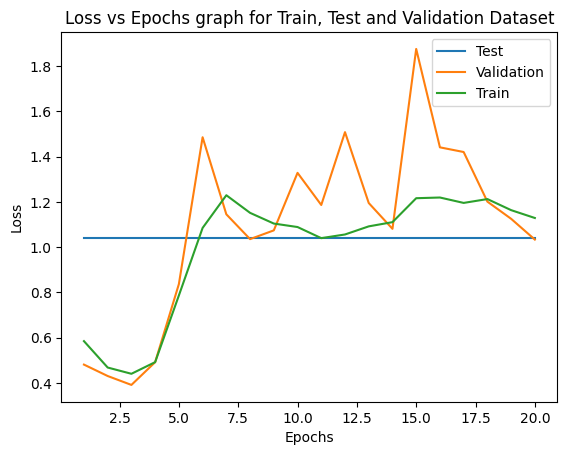

In [ ]:
dropoutModel.plotLossVsEpochs()

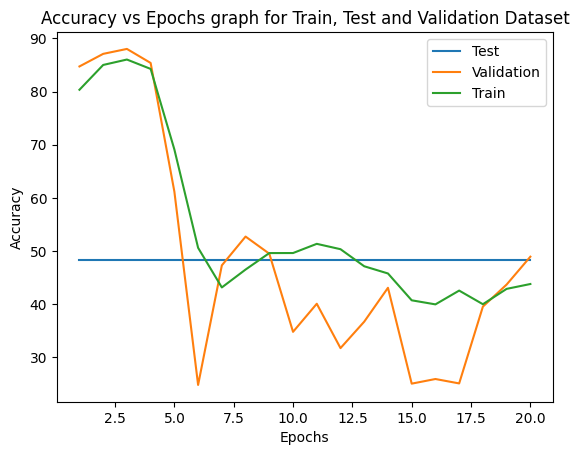

In [ ]:
dropoutModel.plotAccuracyVsEpochs()

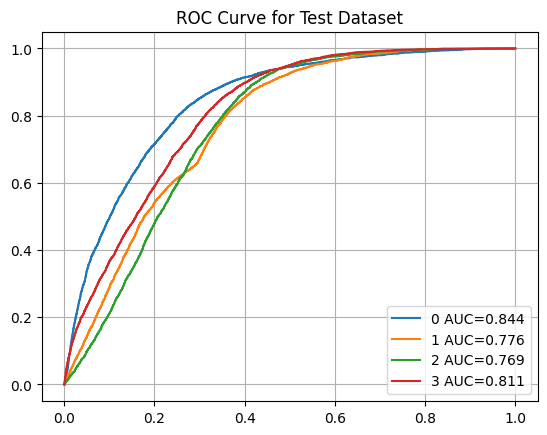

In [ ]:
dropoutModel.plotROCgraph()

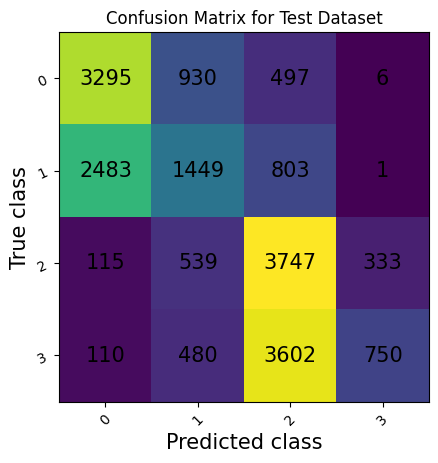

In [ ]:
dropoutModel.plotConfusionMatrix()

# Base Transformer Model with L1 Regularization

In [ ]:
lr=0.01
num_epochs = 20
l1_lambda = 1e-4
l2_lambda = 0
early_stop = False
earlyStopPatience = 10
lr_scheduler = False
lrsPatience = 5
dropoutProb = 0.2
nheads = 4
num_layers = 3
hidden_size = 100
vocab_size = vocab_size
embedding_size = embedding_size
max_seq_length = max_seq_length
num_classes = num_classes
temp_model_path = '/content/textclassification/temp.pth'
final_model_path = '/content/textclassification/l1l2.pth'
trial_save_path = '/content/textclassification/l1l2.pkl'

In [ ]:
regularizationTransformer = BaseTransformer(
    vocab_size = vocab_size,
    embedding_size = embedding_size,
    max_seq_len = max_seq_length,
    num_classes = num_classes,
    nheads = nheads,
    hidden_size = hidden_size,
    num_layers = num_layers,
    dropout = dropoutProb
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(regularizationTransformer.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, threshold_mode = 'rel', mode = 'min', patience=lrsPatience, threshold=0.0001)

In [ ]:
l1l2Model = ModelTrial(regularizationTransformer, criterion, optimizer, scheduler = scheduler, l1_lambda = l1_lambda)

In [ ]:
l1l2Model.printModel()

BaseTransformer(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=100, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=100, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (linear): Linear(in_features=100, out_features=4, bias=True)
)


In [ ]:
l1l2Model.printModelSummary((256, max_seq_length, embedding_size))

Layer (type:depth-idx)                        Output Shape              Param #
BaseTransformer                               [256, 4]                  --
├─PositionalEncoding: 1-1                     [256, 50, 100]            --
│    └─Dropout: 2-1                           [256, 50, 100]            --
├─TransformerEncoder: 1-2                     [256, 50, 100]            --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [256, 50, 100]            61,000
│    │    └─TransformerEncoderLayer: 3-2      [256, 50, 100]            61,000
│    │    └─TransformerEncoderLayer: 3-3      [256, 50, 100]            61,000
├─Linear: 1-3                                 [256, 4]                  404
Total params: 183,404
Trainable params: 183,404
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 5.12
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 5.13


In [ ]:
l1l2Model.trainingLoop(trainLoader = train_loader, validationLoader = valid_loader,
                         num_epochs = num_epochs,
                         temp_model_path = temp_model_path,
                         final_model_path = final_model_path,
                         trial_save_path = trial_save_path,
                         verbose = True, lr_scheduler = lr_scheduler,
                         early_stop = early_stop, patience = earlyStopPatience)

In Epoch 1


100%|██████████| 349/349 [00:11<00:00, 29.32it/s]


Epoch 1, Training Loss: 0.90861, Training Accuracy: 85.59%


100%|██████████| 599/599 [00:02<00:00, 245.69it/s]


Epoch 1, Validation Loss: 0.32058, Validation Accuracy: 90.04%
In Epoch 2


100%|██████████| 349/349 [00:11<00:00, 31.57it/s]


Epoch 2, Training Loss: 0.57614, Training Accuracy: 88.74%


100%|██████████| 599/599 [00:02<00:00, 250.88it/s]


Epoch 2, Validation Loss: 0.32079, Validation Accuracy: 89.86%
In Epoch 3


100%|██████████| 349/349 [00:11<00:00, 31.19it/s]


Epoch 3, Training Loss: 0.52254, Training Accuracy: 89.29%


100%|██████████| 599/599 [00:02<00:00, 244.70it/s]


Epoch 3, Validation Loss: 0.30818, Validation Accuracy: 89.93%
In Epoch 4


100%|██████████| 349/349 [00:11<00:00, 30.17it/s]


Epoch 4, Training Loss: 0.49976, Training Accuracy: 89.54%


100%|██████████| 599/599 [00:02<00:00, 250.08it/s]


Epoch 4, Validation Loss: 0.28741, Validation Accuracy: 90.42%
In Epoch 5


100%|██████████| 349/349 [00:11<00:00, 31.38it/s]


Epoch 5, Training Loss: 0.48342, Training Accuracy: 89.58%


100%|██████████| 599/599 [00:02<00:00, 250.90it/s]


Epoch 5, Validation Loss: 0.29025, Validation Accuracy: 90.72%
In Epoch 6


100%|██████████| 349/349 [00:11<00:00, 30.35it/s]


Epoch 6, Training Loss: 0.46734, Training Accuracy: 89.74%


100%|██████████| 599/599 [00:02<00:00, 246.87it/s]


Epoch 6, Validation Loss: 0.28240, Validation Accuracy: 90.54%
In Epoch 7


100%|██████████| 349/349 [00:11<00:00, 31.24it/s]


Epoch 7, Training Loss: 0.46772, Training Accuracy: 89.69%


100%|██████████| 599/599 [00:02<00:00, 251.81it/s]


Epoch 7, Validation Loss: 0.29135, Validation Accuracy: 90.37%
In Epoch 8


100%|██████████| 349/349 [00:11<00:00, 29.89it/s]


Epoch 8, Training Loss: 0.46291, Training Accuracy: 89.78%


100%|██████████| 599/599 [00:02<00:00, 241.15it/s]


Epoch 8, Validation Loss: 0.29253, Validation Accuracy: 90.42%
In Epoch 9


100%|██████████| 349/349 [00:11<00:00, 29.78it/s]


Epoch 9, Training Loss: 0.45329, Training Accuracy: 89.96%


100%|██████████| 599/599 [00:02<00:00, 238.55it/s]


Epoch 9, Validation Loss: 0.27053, Validation Accuracy: 90.95%
In Epoch 10


100%|██████████| 349/349 [00:11<00:00, 29.39it/s]


Epoch 10, Training Loss: 0.45721, Training Accuracy: 89.89%


100%|██████████| 599/599 [00:02<00:00, 226.36it/s]


Epoch 10, Validation Loss: 0.27611, Validation Accuracy: 90.74%
In Epoch 11


100%|██████████| 349/349 [00:12<00:00, 27.86it/s]


Epoch 11, Training Loss: 0.44939, Training Accuracy: 89.95%


100%|██████████| 599/599 [00:02<00:00, 227.66it/s]


Epoch 11, Validation Loss: 0.27774, Validation Accuracy: 90.69%
In Epoch 12


100%|██████████| 349/349 [00:12<00:00, 28.75it/s]


Epoch 12, Training Loss: 0.44920, Training Accuracy: 90.06%


100%|██████████| 599/599 [00:02<00:00, 230.46it/s]


Epoch 12, Validation Loss: 0.26444, Validation Accuracy: 90.86%
In Epoch 13


100%|██████████| 349/349 [00:12<00:00, 28.59it/s]


Epoch 13, Training Loss: 0.45965, Training Accuracy: 89.82%


100%|██████████| 599/599 [00:02<00:00, 243.96it/s]


Epoch 13, Validation Loss: 0.27683, Validation Accuracy: 90.84%
In Epoch 14


100%|██████████| 349/349 [00:11<00:00, 30.59it/s]


Epoch 14, Training Loss: 0.44991, Training Accuracy: 90.02%


100%|██████████| 599/599 [00:02<00:00, 239.15it/s]


Epoch 14, Validation Loss: 0.28062, Validation Accuracy: 90.72%
In Epoch 15


100%|██████████| 349/349 [00:11<00:00, 30.22it/s]


Epoch 15, Training Loss: 0.45666, Training Accuracy: 89.88%


100%|██████████| 599/599 [00:02<00:00, 242.25it/s]


Epoch 15, Validation Loss: 0.27276, Validation Accuracy: 90.95%
In Epoch 16


100%|██████████| 349/349 [00:11<00:00, 30.74it/s]


Epoch 16, Training Loss: 0.46033, Training Accuracy: 89.98%


100%|██████████| 599/599 [00:02<00:00, 244.83it/s]


Epoch 16, Validation Loss: 0.26636, Validation Accuracy: 91.00%
In Epoch 17


100%|██████████| 349/349 [00:11<00:00, 30.77it/s]


Epoch 17, Training Loss: 0.46070, Training Accuracy: 89.96%


100%|██████████| 599/599 [00:02<00:00, 243.12it/s]


Epoch 17, Validation Loss: 0.27297, Validation Accuracy: 90.75%
In Epoch 18


100%|██████████| 349/349 [00:11<00:00, 31.02it/s]


Epoch 18, Training Loss: 0.45982, Training Accuracy: 89.88%


100%|██████████| 599/599 [00:02<00:00, 240.15it/s]


Epoch 18, Validation Loss: 0.28224, Validation Accuracy: 90.73%
In Epoch 19


100%|██████████| 349/349 [00:11<00:00, 30.93it/s]


Epoch 19, Training Loss: 0.46906, Training Accuracy: 89.90%


100%|██████████| 599/599 [00:02<00:00, 247.95it/s]


Epoch 19, Validation Loss: 0.26974, Validation Accuracy: 90.76%
In Epoch 20


100%|██████████| 349/349 [00:11<00:00, 30.74it/s]


Epoch 20, Training Loss: 0.47524, Training Accuracy: 90.02%


100%|██████████| 599/599 [00:02<00:00, 236.85it/s]


Epoch 20, Validation Loss: 0.26924, Validation Accuracy: 90.95%
Training Ended !!!


In [ ]:
l1l2Model.testDatasetPass(test_loader)

Testing Started!


100%|██████████| 599/599 [00:02<00:00, 231.00it/s]

Testing Completed!!
Testing Loss: 0.27613, Testing Accuracy: 90.56%


In [ ]:
l1l2Model.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 3, Seconds: 51, Microseconds: 307108


In [ ]:
l1l2Model.printMetrics()

Accuracy for Test Dataset at end of training : 90.55904
For Class World: Precision=0.9205, Recall=0.8862, F1 Score=0.9030
For Class Sports: Precision=0.9601, Recall=0.9766, F1 Score=0.9683
For Class Business: Precision=0.8754, Recall=0.8654, F1 Score=0.8704
For Class Sci/Tech: Precision=0.8684, Recall=0.8946, F1 Score=0.8813


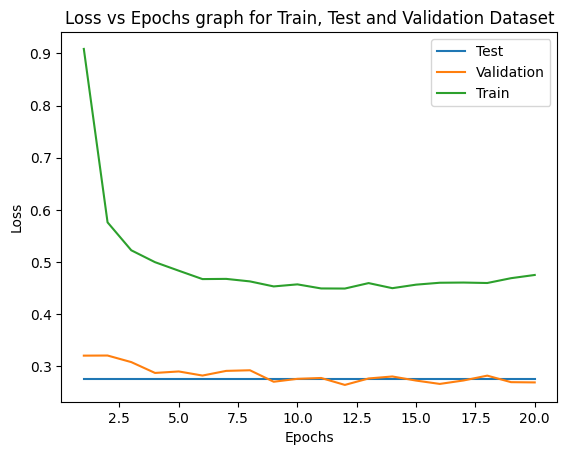

In [ ]:
l1l2Model.plotLossVsEpochs()

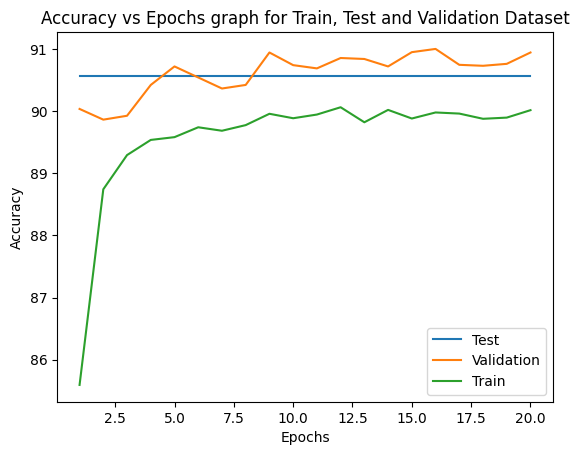

In [ ]:
l1l2Model.plotAccuracyVsEpochs()

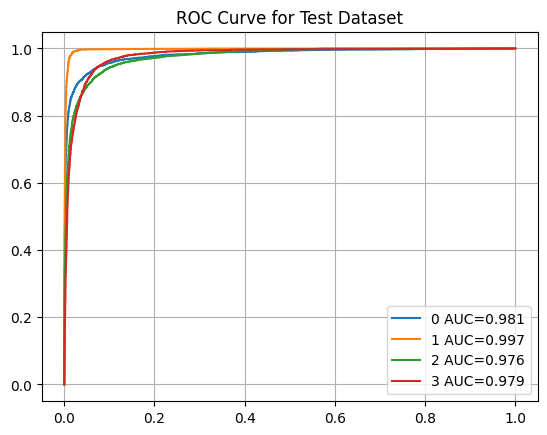

In [ ]:
l1l2Model.plotROCgraph()

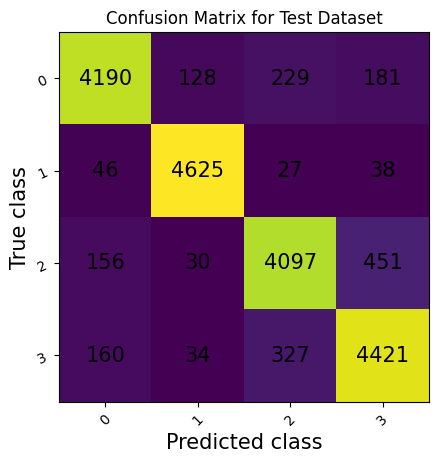

In [ ]:
l1l2Model.plotConfusionMatrix()

# Base Transformer Model with Early Stopping and Learning Rate Scheduler

In [ ]:
lr=0.01
num_epochs = 20
l1_lambda = 1e-4
l2_lambda = 0
early_stop = True
earlyStopPatience = 6
lr_scheduler = True
lrsPatience = 3
dropoutProb = 0.2
nheads = 4
num_layers = 3
hidden_size = 100
vocab_size = vocab_size
embedding_size = embedding_size
max_seq_length = max_seq_length
num_classes = num_classes
temp_model_path = '/content/textclassification/temp.pth'
final_model_path = '/content/textclassification/lrs.pth'
trial_save_path = '/content/textclassification/lrs.pkl'

In [ ]:
lrsTransformer = BaseTransformer(
    vocab_size = vocab_size,
    embedding_size = embedding_size,
    max_seq_len = max_seq_length,
    num_classes = num_classes,
    nheads = nheads,
    hidden_size = hidden_size,
    num_layers = num_layers,
    dropout = dropoutProb
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lrsTransformer.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, threshold_mode = 'rel', mode = 'min', patience=lrsPatience, threshold=0.0001)

In [ ]:
lrsModel = ModelTrial(lrsTransformer, criterion, optimizer, scheduler = scheduler, l1_lambda = l1_lambda)

In [ ]:
lrsModel.printModel()

BaseTransformer(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=100, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=100, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (linear): Linear(in_features=100, out_features=4, bias=True)
)


In [ ]:
lrsModel.printModelSummary((256, max_seq_length, embedding_size))

Layer (type:depth-idx)                        Output Shape              Param #
BaseTransformer                               [256, 4]                  --
├─PositionalEncoding: 1-1                     [256, 50, 100]            --
│    └─Dropout: 2-1                           [256, 50, 100]            --
├─TransformerEncoder: 1-2                     [256, 50, 100]            --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [256, 50, 100]            61,000
│    │    └─TransformerEncoderLayer: 3-2      [256, 50, 100]            61,000
│    │    └─TransformerEncoderLayer: 3-3      [256, 50, 100]            61,000
├─Linear: 1-3                                 [256, 4]                  404
Total params: 183,404
Trainable params: 183,404
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 5.12
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 5.13


In [ ]:
lrsModel.trainingLoop(trainLoader = train_loader, validationLoader = valid_loader,
                         num_epochs = num_epochs,
                         temp_model_path = temp_model_path,
                         final_model_path = final_model_path,
                         trial_save_path = trial_save_path,
                         verbose = True, lr_scheduler = lr_scheduler,
                         early_stop = early_stop, patience = earlyStopPatience)

In Epoch 1


100%|██████████| 349/349 [00:12<00:00, 28.70it/s]


Epoch 1, Training Loss: 1.30731, Training Accuracy: 66.32%


100%|██████████| 599/599 [00:02<00:00, 238.16it/s]


Epoch 1, Validation Loss: 0.36860, Validation Accuracy: 88.28%
In Epoch 2


100%|██████████| 349/349 [00:11<00:00, 30.34it/s]


Epoch 2, Training Loss: 0.61236, Training Accuracy: 88.62%


100%|██████████| 599/599 [00:02<00:00, 247.10it/s]


Epoch 2, Validation Loss: 0.31045, Validation Accuracy: 89.81%
In Epoch 3


100%|██████████| 349/349 [00:11<00:00, 30.55it/s]


Epoch 3, Training Loss: 0.52842, Training Accuracy: 89.18%


100%|██████████| 599/599 [00:02<00:00, 247.78it/s]


Epoch 3, Validation Loss: 0.29495, Validation Accuracy: 90.30%
In Epoch 4


100%|██████████| 349/349 [00:11<00:00, 30.86it/s]


Epoch 4, Training Loss: 0.49484, Training Accuracy: 89.39%


100%|██████████| 599/599 [00:02<00:00, 252.77it/s]


Epoch 4, Validation Loss: 0.28639, Validation Accuracy: 90.65%
In Epoch 5


100%|██████████| 349/349 [00:11<00:00, 30.78it/s]


Epoch 5, Training Loss: 0.48129, Training Accuracy: 89.47%


100%|██████████| 599/599 [00:02<00:00, 249.37it/s]


Epoch 5, Validation Loss: 0.28137, Validation Accuracy: 90.78%
In Epoch 6


100%|██████████| 349/349 [00:11<00:00, 30.79it/s]


Epoch 6, Training Loss: 0.46307, Training Accuracy: 89.62%


100%|██████████| 599/599 [00:02<00:00, 251.89it/s]


Epoch 6, Validation Loss: 0.27325, Validation Accuracy: 90.89%
In Epoch 7


100%|██████████| 349/349 [00:11<00:00, 30.51it/s]


Epoch 7, Training Loss: 0.45221, Training Accuracy: 89.83%


100%|██████████| 599/599 [00:02<00:00, 233.09it/s]


Epoch 7, Validation Loss: 0.26681, Validation Accuracy: 90.60%
In Epoch 8


100%|██████████| 349/349 [00:11<00:00, 29.68it/s]


Epoch 8, Training Loss: 0.45366, Training Accuracy: 89.74%


100%|██████████| 599/599 [00:02<00:00, 238.91it/s]


Epoch 8, Validation Loss: 0.29237, Validation Accuracy: 90.03%
In Epoch 9


100%|██████████| 349/349 [00:11<00:00, 30.08it/s]


Epoch 9, Training Loss: 0.44431, Training Accuracy: 89.83%


100%|██████████| 599/599 [00:02<00:00, 234.42it/s]


Epoch 9, Validation Loss: 0.26584, Validation Accuracy: 90.98%
In Epoch 10


100%|██████████| 349/349 [00:11<00:00, 30.01it/s]


Epoch 10, Training Loss: 0.45287, Training Accuracy: 89.74%


100%|██████████| 599/599 [00:02<00:00, 234.00it/s]


Epoch 10, Validation Loss: 0.27270, Validation Accuracy: 90.66%
In Epoch 11


100%|██████████| 349/349 [00:12<00:00, 27.80it/s]


Epoch 11, Training Loss: 0.44875, Training Accuracy: 89.89%


100%|██████████| 599/599 [00:02<00:00, 238.91it/s]


Epoch 11, Validation Loss: 0.26812, Validation Accuracy: 90.71%
In Epoch 12


100%|██████████| 349/349 [00:11<00:00, 30.91it/s]


Epoch 12, Training Loss: 0.45569, Training Accuracy: 89.87%


100%|██████████| 599/599 [00:02<00:00, 253.72it/s]


Epoch 12, Validation Loss: 0.28226, Validation Accuracy: 90.42%
In Epoch 13


100%|██████████| 349/349 [00:11<00:00, 31.43it/s]


Epoch 13, Training Loss: 0.45295, Training Accuracy: 89.85%


100%|██████████| 599/599 [00:02<00:00, 249.83it/s]


Epoch 13, Validation Loss: 0.27487, Validation Accuracy: 90.55%
In Epoch 14


100%|██████████| 349/349 [00:11<00:00, 29.76it/s]


Epoch 14, Training Loss: 0.40782, Training Accuracy: 90.53%


100%|██████████| 599/599 [00:02<00:00, 236.67it/s]


Epoch 14, Validation Loss: 0.25644, Validation Accuracy: 91.23%
In Epoch 15


100%|██████████| 349/349 [00:11<00:00, 29.50it/s]


Epoch 15, Training Loss: 0.39574, Training Accuracy: 90.66%


100%|██████████| 599/599 [00:02<00:00, 235.32it/s]


Epoch 15, Validation Loss: 0.25189, Validation Accuracy: 91.46%
In Epoch 16


100%|██████████| 349/349 [00:11<00:00, 29.57it/s]


Epoch 16, Training Loss: 0.38665, Training Accuracy: 90.76%


100%|██████████| 599/599 [00:02<00:00, 235.64it/s]


Epoch 16, Validation Loss: 0.25003, Validation Accuracy: 91.47%
In Epoch 17


100%|██████████| 349/349 [00:11<00:00, 29.31it/s]


Epoch 17, Training Loss: 0.37958, Training Accuracy: 90.81%


100%|██████████| 599/599 [00:02<00:00, 234.80it/s]


Epoch 17, Validation Loss: 0.25340, Validation Accuracy: 91.37%
In Epoch 18


100%|██████████| 349/349 [00:11<00:00, 29.69it/s]


Epoch 18, Training Loss: 0.37475, Training Accuracy: 90.86%


100%|██████████| 599/599 [00:02<00:00, 231.23it/s]


Epoch 18, Validation Loss: 0.24368, Validation Accuracy: 91.66%
In Epoch 19


100%|██████████| 349/349 [00:11<00:00, 29.45it/s]


Epoch 19, Training Loss: 0.36672, Training Accuracy: 91.07%


100%|██████████| 599/599 [00:02<00:00, 237.04it/s]


Epoch 19, Validation Loss: 0.24992, Validation Accuracy: 91.61%
In Epoch 20


100%|██████████| 349/349 [00:11<00:00, 29.34it/s]


Epoch 20, Training Loss: 0.36365, Training Accuracy: 91.02%


100%|██████████| 599/599 [00:02<00:00, 232.82it/s]

Epoch 20, Validation Loss: 0.24298, Validation Accuracy: 91.80%
Training Ended !!!


In [ ]:
lrsModel.testDatasetPass(test_loader)

Testing Started!


100%|██████████| 599/599 [00:02<00:00, 232.69it/s]

Testing Completed!!
Testing Loss: 0.24915, Testing Accuracy: 91.29%


In [ ]:
lrsModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 3, Seconds: 53, Microseconds: 319270


In [ ]:
lrsModel.printMetrics()

Accuracy for Test Dataset at end of training : 91.28527
For Class World: Precision=0.9239, Recall=0.8989, F1 Score=0.9112
For Class Sports: Precision=0.9581, Recall=0.9844, F1 Score=0.9710
For Class Business: Precision=0.8823, Recall=0.8821, F1 Score=0.8822
For Class Sci/Tech: Precision=0.8873, Recall=0.8871, F1 Score=0.8872


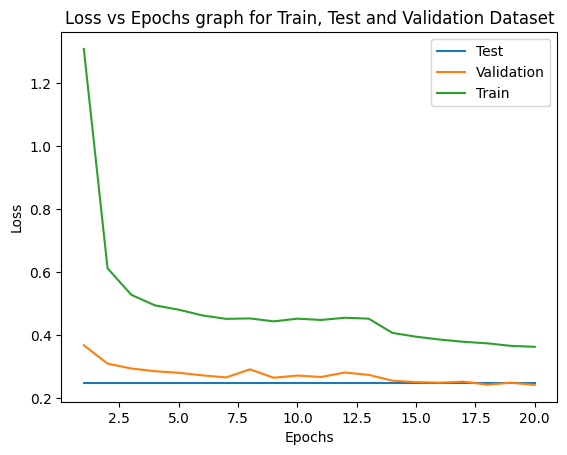

In [ ]:
lrsModel.plotLossVsEpochs()

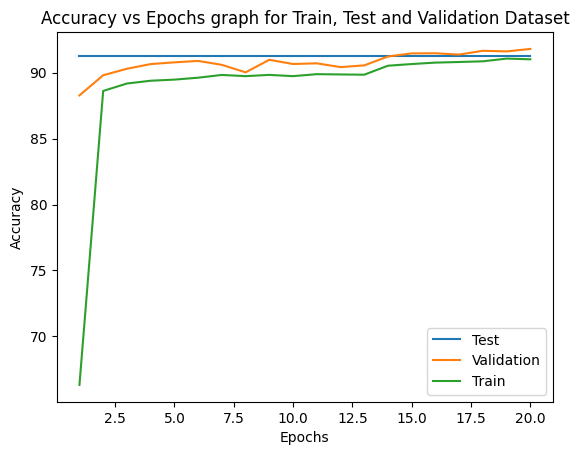

In [ ]:
lrsModel.plotAccuracyVsEpochs()

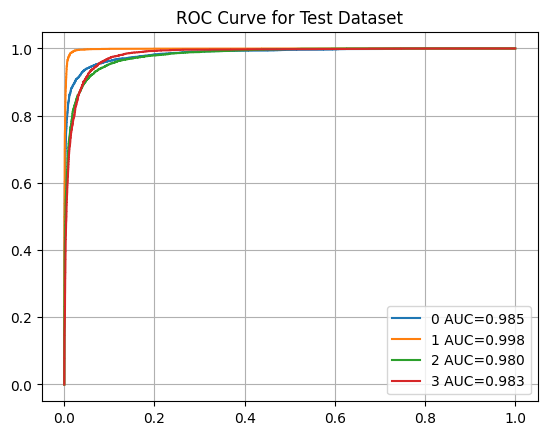

In [ ]:
lrsModel.plotROCgraph()

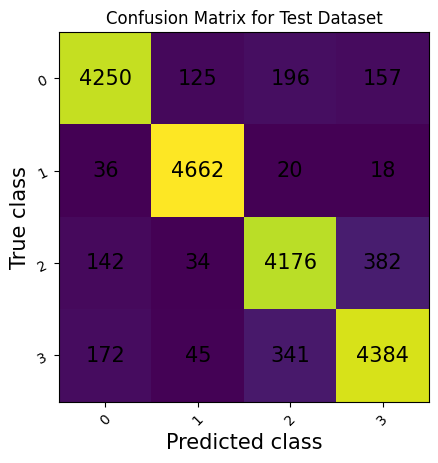

In [ ]:
lrsModel.plotConfusionMatrix()

#### References
1.	https://docs.python.org/3/index.html

2.	https://matplotlib.org/stable/

3.	https://seaborn.pydata.org/api.html

4.	https://pandas.pydata.org/docs/reference/index.html

5.	https://numpy.org/doc/stable/index.html

6.	https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

7.	https://torchmetrics.readthedocs.io/en/stable/

8.	https://scikit-learn.org/stable/modules/classes.html

9.	https://radimrehurek.com/gensim/auto_examples/index.html#documentation

10. https://pytorch.org/text/stable/index.html

11. https://pytorch.org/tutorials/beginner/transformer_tutorial.html

12.	https://pytorch.org/docs/stable/index.html

13.	https://github.com/TylerYep/torchinfo#readme